In [142]:
%matplotlib inline

## Import stuff

In [143]:
import os
import sys
sys.path.append('../code')
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import tensorflow as tf

# from LatEvModels import LocallyLinearEvolution
# from ObservationModels import PoissonObs
# from RecognitionModels import SmoothingNLDSTimeSeries

DTYPE = tf.float32

In [144]:
import pickle
datafile = '/Users/danielhernandez/work/supervind/data/ziqiang/datadict'
with open(datafile, 'rb+') as f:
    # Set encoding='latin1' for python 2 pickled data
    datadict = pickle.load(f, encoding='latin1')
    Ytrain = datadict['Ytrain'].astype(np.float32)
    Yvalid = datadict['Yvalid'].astype(np.float32)


In [145]:
print(datadict.keys())
print(datadict['TargetValid'])

dict_keys(['Yvalid', 'Ytrain', 'TargetValid', 'TargetTrain'])
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Load the stored graph for this fit.

### (Only need to do this once)

In [204]:
metafile = '/Users/danielhernandez/work/supervind/rslts/ziqiang/_D180402_1807/vaec-11781.meta'
tf.reset_default_graph()
saver = tf.train.import_meta_graph(metafile)

# Restore the latest checkpoint, fire a session and compute the inferred paths and prediction statistics for the data such as the kMSE

## Store all predictions in `Ypreds`

In [411]:
rslt_dir = '/Users/danielhernandez/work/supervind/rslts/ziqiang/_D180402_1807/'
sess = tf.Session()
saver.restore(sess, tf.train.latest_checkpoint(rslt_dir))
k = 20
Yvalid_shp = Yvalid.shape
Ypreds = np.zeros([3, k] + list(Yvalid_shp))
with sess.as_default():
    # Note that 2 fixed-point iterations yield a good approximation to the fixed point
    X0 = sess.run('VAEC/recog_nn_mu/MuX:0', feed_dict={'VAEC/Y:0' : Yvalid}) 
    X1 = sess.run('VAEC/postX_ng:0', feed_dict={'VAEC/Y:0' : Yvalid, 'VAEC/X:0' : X0})
    X2 = sess.run('VAEC/postX_ng:0', feed_dict={'VAEC/Y:0' : Yvalid, 'VAEC/X:0' : X1})
    Xn0, Xn1, Xn2 = X0, X1, X2

    outY0 = sess.run('VAEC/obs_nn/outY:0', feed_dict={'VAEC/X:0' : Xn0})
    outY1 = sess.run('VAEC/obs_nn/outY:0', feed_dict={'VAEC/X:0' : Xn1})
    outY2 = sess.run('VAEC/obs_nn/outY:0', feed_dict={'VAEC/X:0' : Xn2})

    Ypreds[0, 0] = outY0
    Ypreds[1, 0] = outY1
    Ypreds[2, 0] = outY2
    
    kMSE = np.zeros((3, k))
    kMSE[0, 0] = np.sum((Yvalid - outY0)**2)/len(Yvalid)
    kMSE[1, 0] = np.sum((Yvalid - outY1)**2)/len(Yvalid)
    kMSE[2, 0] = np.sum((Yvalid - outY2)**2)/len(Yvalid)
    for j in range(1, k):
        A0 = sess.run('VAEC/A:0', feed_dict={'VAEC/X:0' : Xn0})
        A1 = sess.run('VAEC/A:0', feed_dict={'VAEC/X:0' : Xn1})
        A2 = sess.run('VAEC/A:0', feed_dict={'VAEC/X:0' : Xn2})

        Xn0 = np.einsum('ijk,ijkl->ijl', Xn0, A0)
        Xn1 = np.einsum('ijk,ijkl->ijl', Xn1, A1)
        Xn2 = np.einsum('ijk,ijkl->ijl', Xn2, A2)

        outY0 = sess.run('VAEC/obs_nn/outY:0', feed_dict={'VAEC/X:0' : Xn0})
        outY1 = sess.run('VAEC/obs_nn/outY:0', feed_dict={'VAEC/X:0' : Xn1})
        outY2 = sess.run('VAEC/obs_nn/outY:0', feed_dict={'VAEC/X:0' : Xn2})
        
        Ypreds[0, j] = outY0
        Ypreds[1, j] = outY1
        Ypreds[2, j] = outY2

        kMSE[0, j] = np.sum((Yvalid[:,j:] - outY0[:,:-j])**2)/(len(Yvalid)-j) 
        kMSE[1, j] = np.sum((Yvalid[:,j:] - outY1[:,:-j])**2)/(len(Yvalid)-j)
        kMSE[2, j] = np.sum((Yvalid[:,j:] - outY2[:,:-j])**2)/(len(Yvalid)-j)
        
    

INFO:tensorflow:Restoring parameters from /Users/danielhernandez/work/supervind/rslts/ziqiang/_D180402_1807/vaec-11781


## Plot the kMSEs

In [399]:
print(A0[0,0])
print(A1[0,0])

[[ 0.92149687 -0.09626722 -0.02327625 -0.21704683]
 [-0.13350701  0.74156702 -0.0342776  -0.14545688]
 [-0.00860688 -0.01537517  1.01170111 -0.01766788]
 [ 0.01399287 -0.17734687 -0.00147748  0.86085993]]
[[ 0.92149687 -0.09626722 -0.02327625 -0.21704683]
 [-0.13350701  0.74156702 -0.0342776  -0.14545688]
 [-0.00860688 -0.01537517  1.01170111 -0.01766788]
 [ 0.01399287 -0.17734687 -0.00147748  0.86085993]]


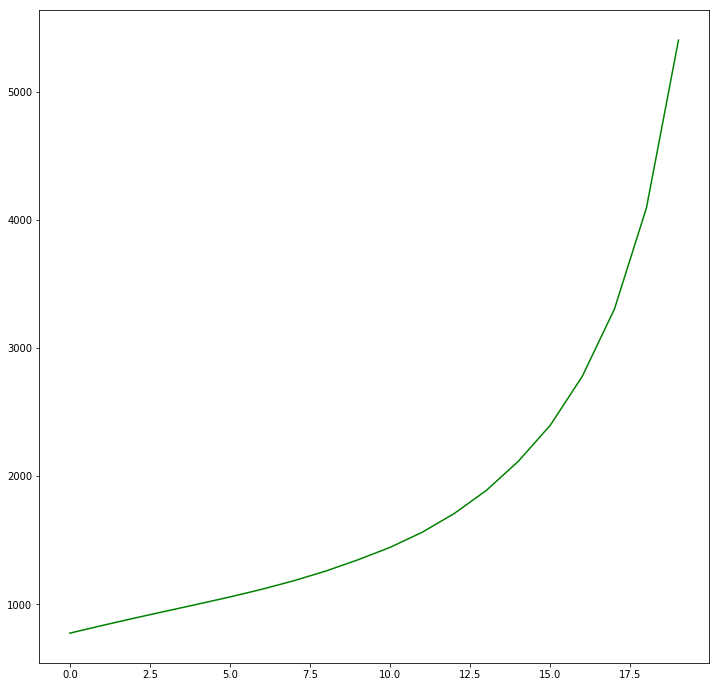

In [210]:
plt.figure(figsize=(12,12))
# plt.plot(totalDeltaY[0], color='r')
# plt.plot(kMSE[1], color='y')
plt.plot(kMSE[2], color='g')

## This shows the data and the prediction together k steps ahead. It may give clues about when and where the kMSE starts to fail

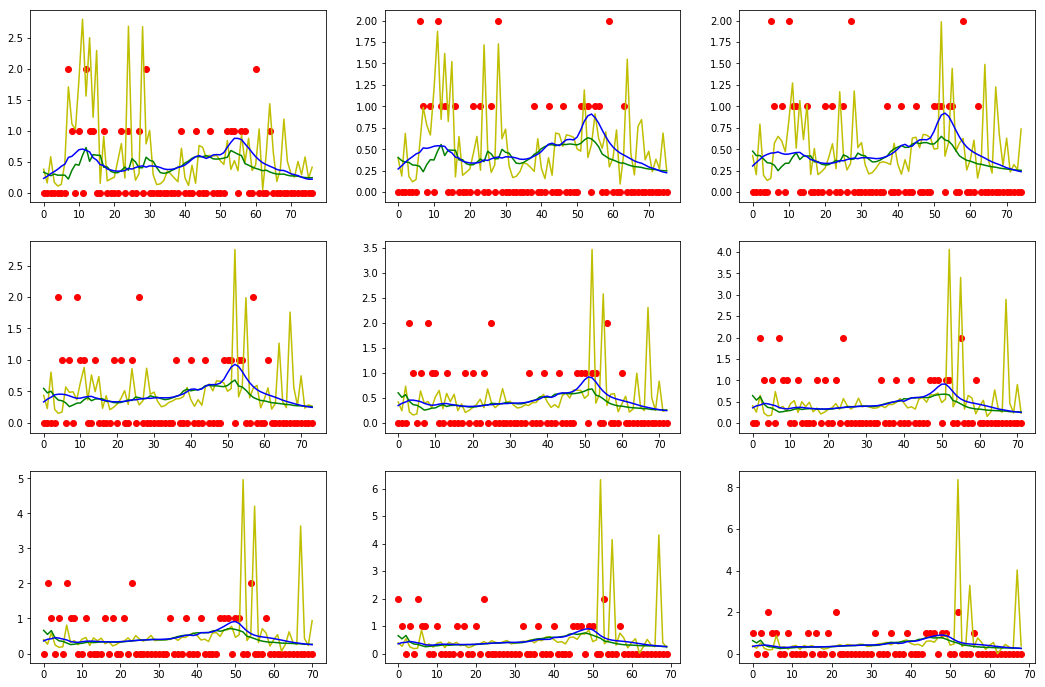

In [149]:
yd = 1
tr = 1
k = 0
Tbins = len(Yvalid[0])
fig, ax = plt.subplots(3,3, figsize=(18,12))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(np.arange(0, len(Yvalid[0][k:])), Yvalid[tr, k:, yd], color='r')
        ax[i,j].plot(Ypreds[0,k, tr,:Tbins-k,yd], color='y')
        ax[i,j].plot(Ypreds[1,k, tr,:Tbins-k,yd], color='g')
        ax[i,j].plot(Ypreds[2,k, tr,:Tbins-k,yd], color='b')
        
        k += 1

## The true latent space trajectories in time

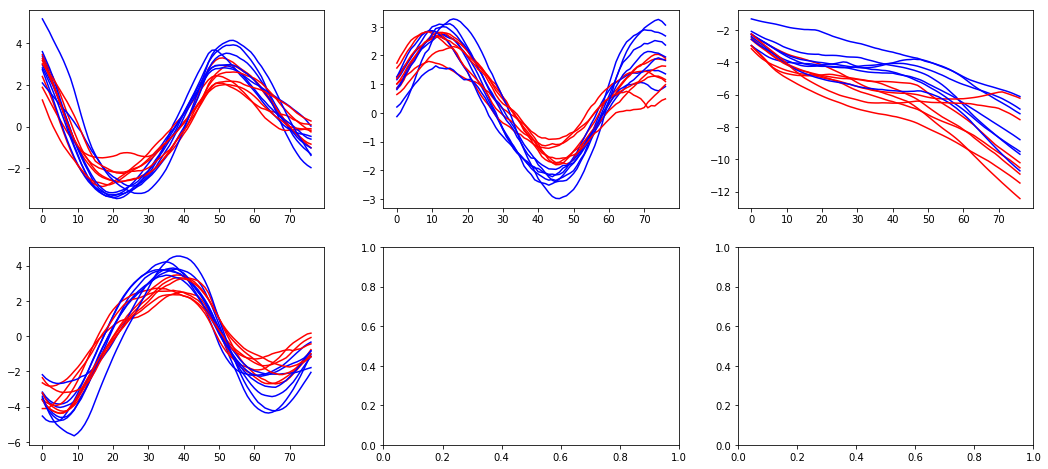

In [211]:
fig, ax = plt.subplots(2,3, figsize=(18,8))
for i in range(7):
    ax[0,0].plot(X2[i,:,0], color='b')
    ax[0,0].plot(X2[7+i,:,0], color='r')
    ax[0,1].plot(X2[i,:,1], color='b')
    ax[0,1].plot(X2[7+i,:,1], color='r')
    ax[0,2].plot(X2[i,:,2], color='b')
    ax[0,2].plot(X2[7+i,:,2], color='r')
    ax[1,0].plot(X2[i,:,3], color='b')
    ax[1,0].plot(X2[7+i,:,3], color='r')

## The latent paths for validation data.

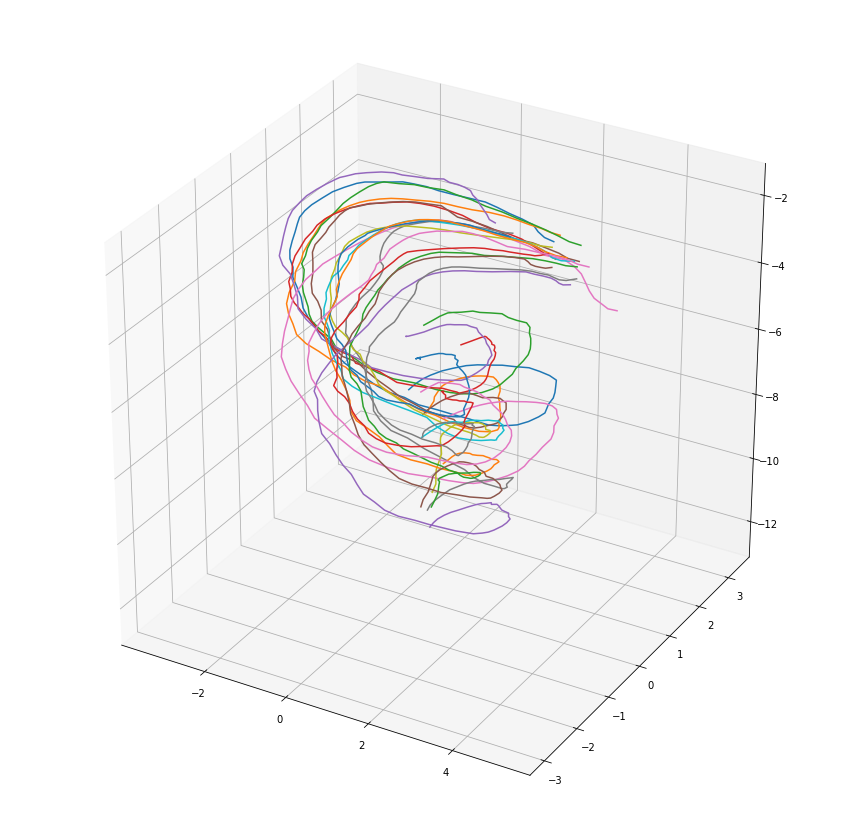

In [212]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
for i in range(18):
    ax.plot(X2[i,:,0], X2[i,:,1], X2[i,:,2], label='parametric curve')
plt.show()

## Plot just 2 to better see what's happening. There seem to be 3 sharp turns in latent space at time bins around 20, 42 and 56 

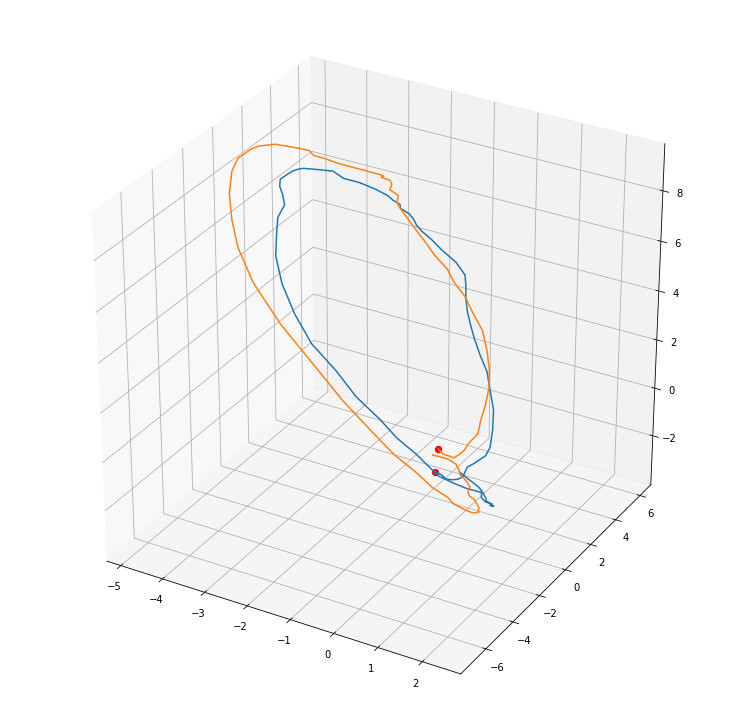

In [152]:
fig = plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')
x, y, z = 0,1,2
for i in range(2):
    ax.plot(X2[i,:,x], X2[i,:,y], X2[i,:,z], label='parametric curve')
    ax.scatter(X2[i,0,x], X2[i,0,y], X2[i,0,z], 'bo', s=40, color='red')
#     ax.scatter(Xpassed_NxTxd[i,20,x], Xpassed_NxTxd[i,20,y], Xpassed_NxTxd[i,20,z], 'bo', s=40, color='orange')
#     ax.scatter(Xpassed_NxTxd[i,42,x], Xpassed_NxTxd[i,42,y], Xpassed_NxTxd[i,42,z], 'bo', s=40, color='green')
#     ax.scatter(Xpassed_NxTxd[i,56,x], Xpassed_NxTxd[i,56,y], Xpassed_NxTxd[i,56,z], 'bo', s=40, color='blue')
plt.show()


In [585]:
# metafile_a = '/Users/danielhernandez/work/supervind/rslts/ziqiang/_D180404_0225/vaec-6171.meta'
metafile_a = '/Users/danielhernandez/work/supervind/rslts/ziqiang/_D180404_1531/vaec-4641.meta'
tf.reset_default_graph()
saver_a = tf.train.import_meta_graph(metafile_a)

In [ ]:
kMSE_4Dl = kMSE_a

In [586]:
rslt_dir = '/Users/danielhernandez/work/supervind/rslts/ziqiang/_D180404_1531/'
sess_a = tf.Session()
saver.restore(sess_a, tf.train.latest_checkpoint(rslt_dir))
k = 20
fpis = 9
xd = 4
Yvalid_shp_a = Yvalid.shape
Ypreds_a = np.zeros([fpis, k] + list(Yvalid_shp_a))
Xpreds_a = np.zeros([fpis, k] + list(Yvalid_shp_a)[:-1] + [xd])
kMSE_a = np.zeros((fpis, k))
with sess_a.as_default():
    # Note that >= 2 fixed-point iterations yield a good approximation to the fixed point
    Xpreds_a[0, 0] = sess_a.run('VAEC/recog_nn_mu/MuX:0', feed_dict={'VAEC/Y:0' : Yvalid})
    Ypreds_a[0,0] = sess_a.run('VAEC/obs_nn/outY:0', feed_dict={'VAEC/X:0' : Xpreds_a[0,0]})
    kMSE_a[0, 0] = np.sum((Yvalid - Ypreds_a[0,0])**2)/len(Yvalid)
    for i in range(1,fpis):
        Xpreds_a[i, 0] = sess_a.run('VAEC/postX_ng:0', feed_dict={'VAEC/Y:0' : Yvalid, 'VAEC/X:0' : Xpreds_a[i-1,0]})
        Ypreds_a[i,0] = sess_a.run('VAEC/obs_nn/outY:0', feed_dict={'VAEC/X:0' : Xpreds_a[i,0]})
        kMSE_a[i, 0] = np.sum((Yvalid - Ypreds_a[i,0])**2)/len(Yvalid)

    for j in range(1, k):
        for i in range(fpis):
            Aa = sess_a.run('VAEC/A:0', feed_dict={'VAEC/X:0' : Xpreds_a[i, j-1]})
            Xpreds_a[i,j] = np.einsum('ijk,ijkl->ijl', Xpreds_a[i, j-1], Aa)
            Ypreds_a[i,j] = sess_a.run('VAEC/obs_nn/outY:0', feed_dict={'VAEC/X:0' : Xpreds_a[i,j]})
            kMSE_a[i, j] = np.sum((Yvalid[:,j:] - Ypreds_a[i,j,:,:-j])**2)/(len(Yvalid)-j)
        

INFO:tensorflow:Restoring parameters from /Users/danielhernandez/work/supervind/rslts/ziqiang/_D180404_1531/vaec-4641


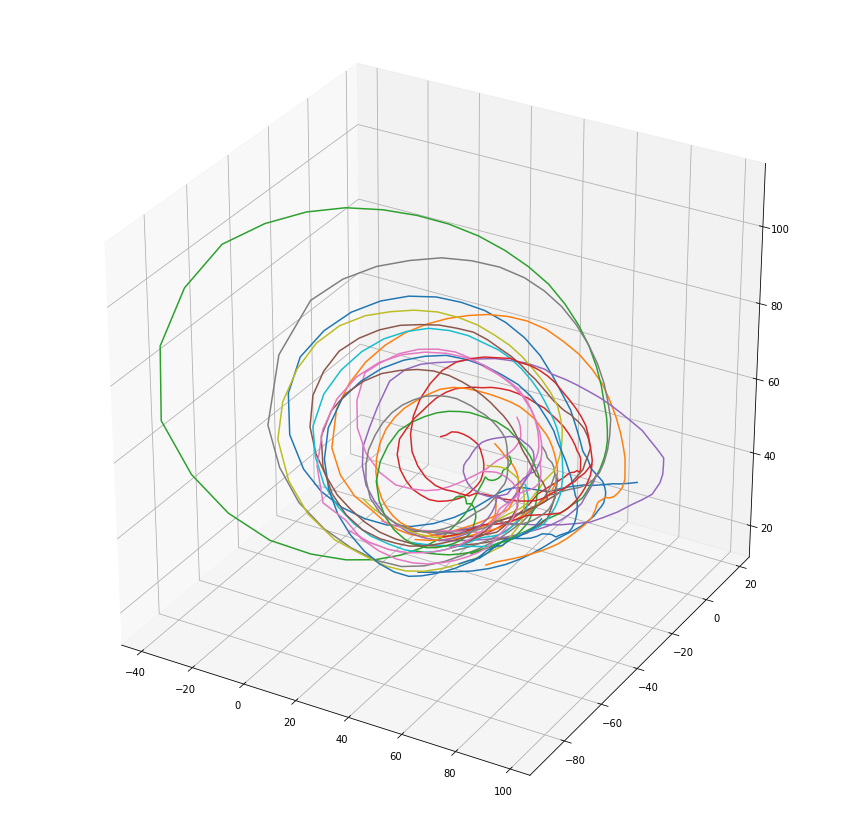

In [582]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
fpi = 7
for i in range(18):
    ax.plot(Xpreds_a[fpi,0,i,:,0], Xpreds_a[fpi,0,i,:,1], Xpreds_a[fpi,0,i,:,2], label='parametric curve')
plt.show()

In [572]:
print(Aa[0,0])
print(Aa[0,1])
print(Aa[0,40])

[[ 0.93163556 -0.10640078  0.07231583  0.02476355]
 [ 0.00411326  1.00036001  0.03371017  0.05372689]
 [-0.09424564  0.00553564  0.90460932 -0.05790217]
 [-0.01651532  0.01604036  0.0251011   0.92089981]]
[[ 0.93059659 -0.10656612  0.07199885  0.02364061]
 [ 0.00667407  1.00108135  0.03252091  0.05631015]
 [-0.09247388  0.00658638  0.90307355 -0.05621075]
 [-0.0137224   0.01762475  0.02493222  0.92162478]]
[[ 0.90606546 -0.08382521  0.0231699   0.01338776]
 [ 0.00255439  0.9055239   0.08269843  0.02782786]
 [-0.1210579   0.02314843  0.91639817 -0.08256385]
 [-0.0040458  -0.00512509  0.03750969  0.92106259]]


## Plot the kMSE for different latent space dimensions together

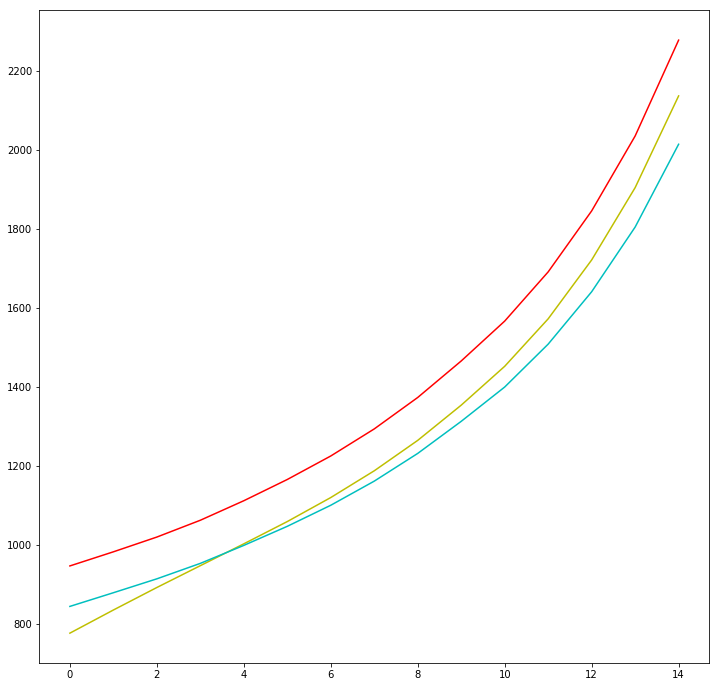

In [583]:

plt.figure(figsize=(12,12))
# plt.plot(kMSE[1], color='r')
plt.plot(kMSE[2][:15], color='y')
# plt.plot(kMSE_a[1], color='g')
# plt.plot(kMSE_a[2][:15], color='g')
# plt.plot(kMSE_a[3][:10], color='c')
# plt.plot(kMSE_4Dnl[6][:15], color='b')
plt.plot(kMSE_4Dl[6][:15], color='c')
plt.plot(kMSE_a[6][:15], color='r')
# plt.plot(kMSE_a[5][:10], color='r')

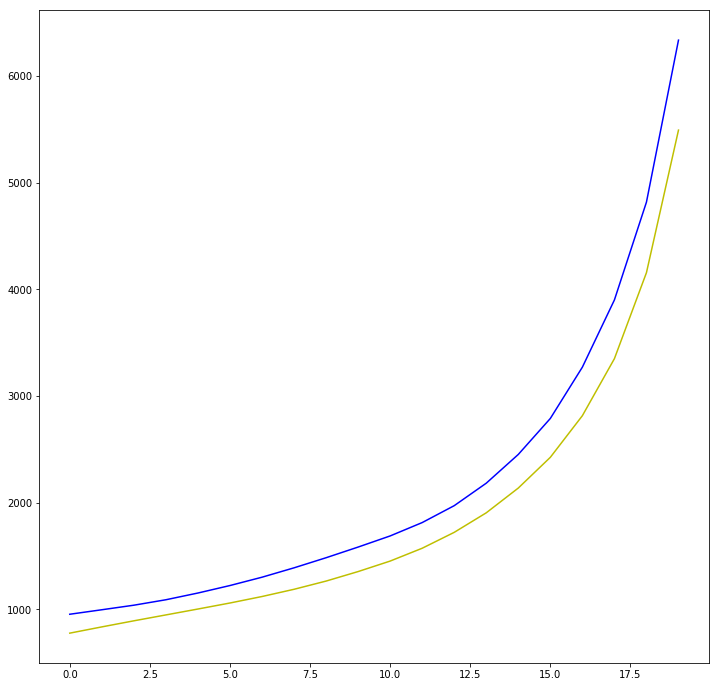

In [524]:
plt.figure(figsize=(12,12))
# plt.plot(kMSE[1], color='r')
plt.plot(kMSE[2], color='y', label='linear')
# plt.plot(kMSE_a[1], color='g')
plt.plot(kMSE_a[2], color='b')

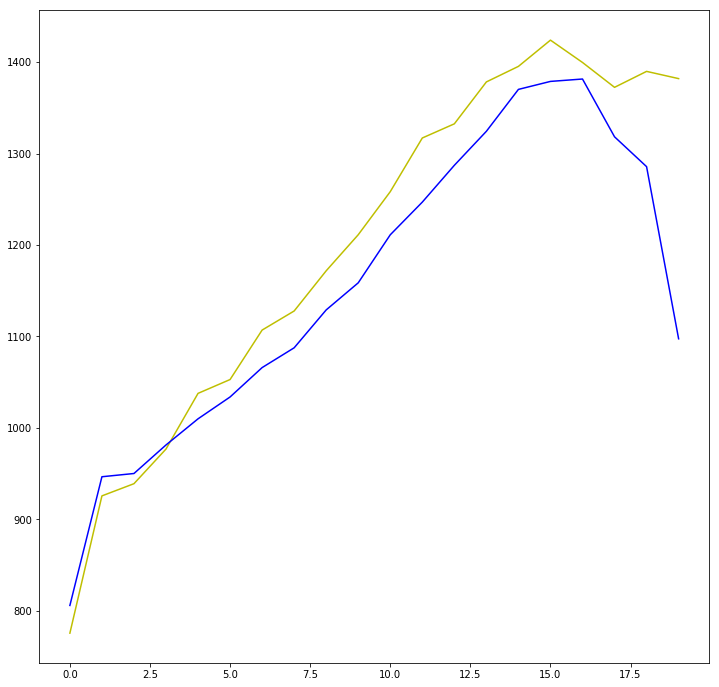

In [191]:
plt.figure(figsize=(12,12))
# plt.plot(kMSE[1], color='r')
plt.plot(kMSE[2], color='y', label='linear')
# plt.plot(kMSE_a[1], color='g')
plt.plot(kMSE_a[2], color='b')

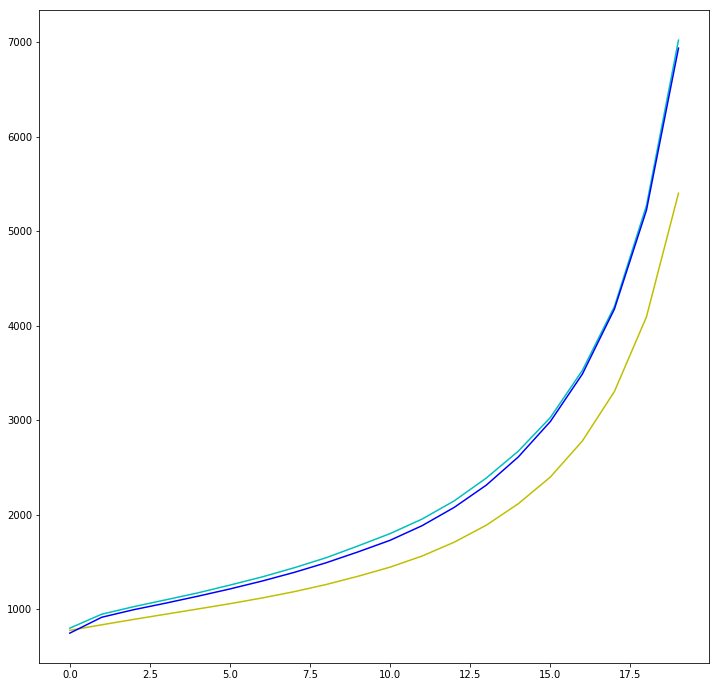

In [227]:
plt.figure(figsize=(12,12))
# plt.plot(kMSE[1], color='r')
plt.plot(kMSE[2], color='y', label='linear')
# plt.plot(kMSE_a[1], color='g')
plt.plot(kMSE_a[2], color='c')
plt.plot(kMSE_a[3], color='b')

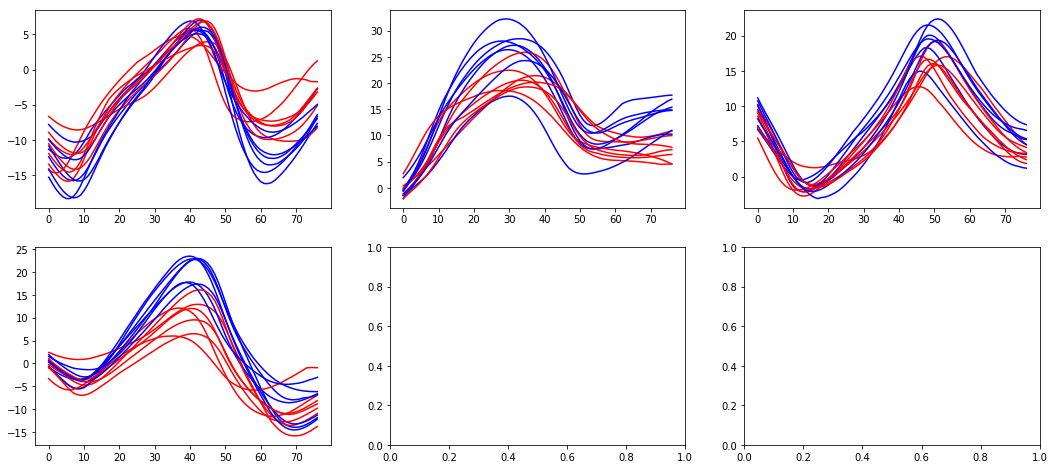

In [575]:
fig, ax = plt.subplots(2,3, figsize=(18,8))
fpi = 5
for i in range(7):
    ax[0,0].plot(Xpreds_a[fpi,0,i,:,0], color='b')
    ax[0,0].plot(Xpreds_a[fpi,0,7+i,:,0], color='r')
    ax[0,1].plot(Xpreds_a[fpi,0,i,:,1], color='b')
    ax[0,1].plot(Xpreds_a[fpi,0,7+i,:,1], color='r')
    ax[0,2].plot(Xpreds_a[fpi,0,i,:,2], color='b')
    ax[0,2].plot(Xpreds_a[fpi,0,7+i,:,2], color='r')
    
    ax[1,0].plot(Xpreds_a[fpi,0,i,:,3], color='b')
    ax[1,0].plot(Xpreds_a[fpi,0,7+i,:,3], color='r')
    

fpi = 4
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
for i in range(18):
    ax.plot(Xpreds_a[fpi,0,i,:,0], Xpreds_a[fpi,0,i,:,1], Xpreds_a[fpi,0,i,:,2], label='parametric curve')
plt.show()